# PyTorch FashionMNIST

In [266]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import random
import math

In [267]:
num_epochs = 5;
batch_size = 100;
learning_rate = 0.001;

In [268]:
class FashionMNISTDataset(Dataset):
    '''Fashion MNIST Dataset'''
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            transform (callable): Optional transform to apply to sample
        """
        
        data = pd.read_csv(csv_file);
        self.X = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28)#.astype(float);
        self.Y = np.array(data.iloc[:, 0]);
        
        del data;
        self.transform = transform;
        
    def __len__(self):
        return len(self.X);
    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        
        if self.transform:
            item = self.transform(item);
        
        return (item, label);

In [271]:
train_dataset = FashionMNISTDataset(csv_file='../data/fashion_mnist/fashion-mnist_train.csv.zip');
test_dataset = FashionMNISTDataset(csv_file='../data/fashion_mnist/fashion-mnist_test.csv.zip')

In [272]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True);

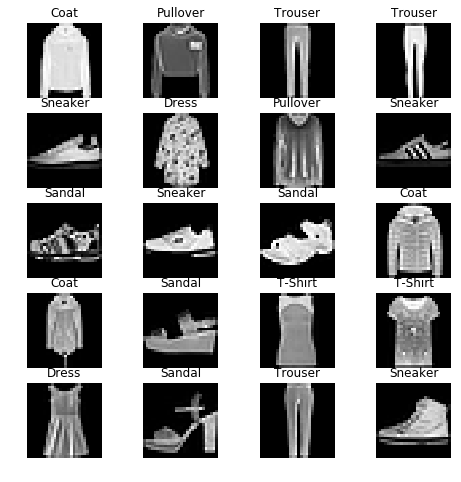

In [273]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [274]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [275]:
#instance of the Conv Net
cnn = CNN();
#loss function and optimizer
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate);

In [276]:
losses = [];
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data[0]);
        
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

Epoch : 1/5, Iter : 100/600,  Loss: 0.3813
Epoch : 1/5, Iter : 200/600,  Loss: 0.4094
Epoch : 1/5, Iter : 300/600,  Loss: 0.3463
Epoch : 1/5, Iter : 400/600,  Loss: 0.3281
Epoch : 1/5, Iter : 500/600,  Loss: 0.3435
Epoch : 1/5, Iter : 600/600,  Loss: 0.1716
Epoch : 2/5, Iter : 100/600,  Loss: 0.2786
Epoch : 2/5, Iter : 200/600,  Loss: 0.1846
Epoch : 2/5, Iter : 300/600,  Loss: 0.2008
Epoch : 2/5, Iter : 400/600,  Loss: 0.2015
Epoch : 2/5, Iter : 500/600,  Loss: 0.2019
Epoch : 2/5, Iter : 600/600,  Loss: 0.3123
Epoch : 3/5, Iter : 100/600,  Loss: 0.2517
Epoch : 3/5, Iter : 200/600,  Loss: 0.4860
Epoch : 3/5, Iter : 300/600,  Loss: 0.2795
Epoch : 3/5, Iter : 400/600,  Loss: 0.3958
Epoch : 3/5, Iter : 500/600,  Loss: 0.2339
Epoch : 3/5, Iter : 600/600,  Loss: 0.1789
Epoch : 4/5, Iter : 100/600,  Loss: 0.2586
Epoch : 4/5, Iter : 200/600,  Loss: 0.1551
Epoch : 4/5, Iter : 300/600,  Loss: 0.1319
Epoch : 4/5, Iter : 400/600,  Loss: 0.2287
Epoch : 4/5, Iter : 500/600,  Loss: 0.3508
Epoch : 4/5

In [277]:
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on the 10000 test images: 90.0000 %


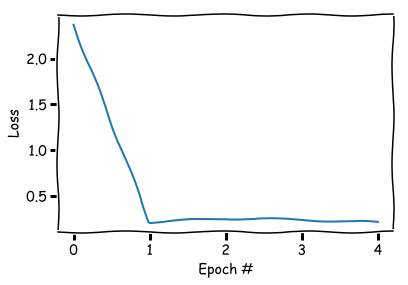

In [278]:
losses_in_epochs = losses[0::600]
plt.xkcd();
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses_in_epochs);
plt.show();

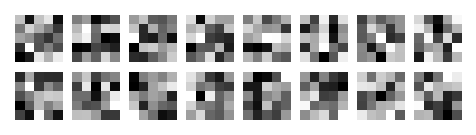

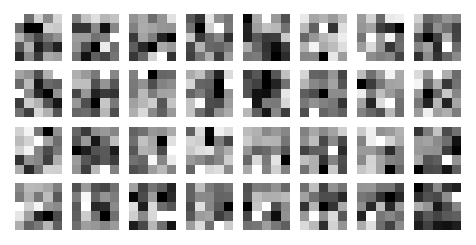

In [280]:
def plot_kernels(tensor, num_cols=6):
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i][0,:,:], cmap='gray')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
filters = cnn.modules();
model_layers = [i for i in cnn.children()];
first_layer = model_layers[0];
second_layer = model_layers[1];
first_kernels = first_layer[0].weight.data.numpy()
plot_kernels(first_kernels, 8)
second_kernels = second_layer[0].weight.data.numpy()
plot_kernels(second_kernels, 8)